# Calcuting Pi by Throwing Darts (serial)

In [1]:
# We're going to disable NumPy's low-level multithreading capabilties
# NumPy is a C library that uses OpenMP to get around Python's GIL
# By setting these OS variables to 1, we have no multithreading, and will parallelize using python multiprocessing
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
import numpy as np

In [2]:
def calculate_pi(darts):
    """approximate pi by thowing darts at a board"""
    x = np.random.uniform(-1, 1, darts)
    y = np.random.uniform(-1, 1, darts)
    r_sq = x**2 + y**2
    return 4*np.sum(r_sq<1)/darts

In [3]:
calculate_pi(10_000)

3.1476

In [4]:
# lets' time throwing 10,000 darts
%timeit calculate_pi(10_000)

214 µs ± 59.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Parallelization with multiprocessing.Process

In [5]:
import multiprocessing
from multiprocessing import Process

In [8]:
def calculate_pi_serial(darts, queue):
    """calculate pi and store it in a queue (serial function)"""
    np.random.seed() # we need to set the random seed... see what happens if you comment this line out
    x = np.random.uniform(-1, 1, darts)
    y = np.random.uniform(-1, 1, darts)
    r_sq = x**2 + y**2
    queue.put(4*np.sum(r_sq<1)/darts)  # instead of returning, we will put the result in "queue"

def calculate_pi_parallel(darts_per_process, Ncores):
    """use the serial function per-process; launch multiple processes"""
    processes = []  # the processes to be running in parallel
    queue = [] # each process has a queue that will store its result

    for i in range(Ncores):
        q = multiprocessing.Queue()
        p = Process(target=calculate_pi_serial, args=(darts_per_process,q))
        p.start()  # the process will start running in the background
        processes.append(p)
        queue.append(q)
    for p in processes:
        p.join()  # we wait for each process to finish
    
    # finally, we average the results from all processes
    total = 0
    for q in queue:
        total += q.get()
    return np.sum(total)/Ncores

In [9]:
calculate_pi_parallel(2500, 4)

3.0984

In [10]:
# let's time running 10,000 darts (4 processes, 2,500 darts each)
%timeit calculate_pi_parallel(2500, 4)

12.8 ms ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This is much slower than the serial version... why is that?

# Parallelizing with multiprocessing.Pool

Let's simplify the code a bit by using a Pool instead of a Process.

In [13]:
from multiprocessing import Pool

In [14]:
def calculate_pi_serial(darts):
    """calculate pi and store it in a queue (serial function)"""
    np.random.seed()
    x = np.random.uniform(-1, 1, darts)
    y = np.random.uniform(-1, 1, darts)
    r_sq = x**2 + y**2
    return 4*np.sum(r_sq<1)/darts

def calculate_pi_parallel(darts_per_process, Ncores):
    """use the serial function per-process; launch multiple processes"""
    with Pool(Ncores) as pool:
        results = pool.map(calculate_pi_serial, [darts_per_process for i in range(Ncores)])

    return np.sum(results)/Ncores

In [15]:
calculate_pi_parallel(2500, 4)

3.1612

In [17]:
%timeit calculate_pi_parallel(2500, 4)

12.5 ms ± 13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The Pool code is easier to write then the Process code, but they do effectively the same thing. Performance is still worse than serial.

# Parallelization won't work well unless the problem is sufficiently difficult

In [24]:
N = 20_000_000

In [25]:
# it takes about 575 ms to throw 20 mil darts
%timeit calculate_pi_serial(N)

575 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
# with 4 processors, you can throw 20 mil darts (5 mil each), in 155 ms (~3.7 times faster)
%timeit calculate_pi_parallel(N//4, 4)

155 ms ± 72.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
# with 8 processors, it taks ~138 ms, which is only ~4.2 times faster than serial.
# we would need to throw many more darts to get closer to 8X speedup with 8 processors
# try increasing N further
%timeit calculate_pi_parallel(N//8, 8)

138 ms ± 694 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


When we threw 10,000 darts, it only took 200 micro-seconds in serial. It's very difficult to parallelize something that is already so fast in serial.

But with 20 million darts, the serial version takes over a second. Parallelization is very effective here

# Scaling: weak vs strong

In [28]:
from timeit import timeit
import matplotlib.pyplot as plt

In [29]:
Ncores = range(1,9)
times = np.array([timeit(lambda: calculate_pi_parallel(N//Nc, Nc), number=1) for Nc in Ncores])

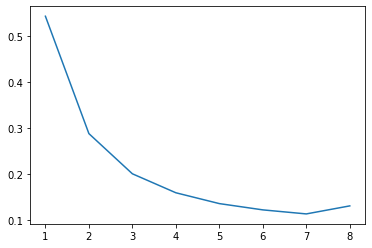

In [30]:
plt.plot(Ncores, times)

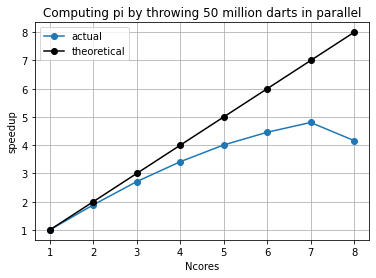

In [31]:
speedup = times[0]/times
plt.plot(Ncores, speedup, 'o-', label='actual')
plt.plot(Ncores, Ncores, 'o-', color='k', label='theoretical')
plt.title('Computing pi by throwing 20 million darts in parallel')
plt.gca().set(xlabel='Ncores', ylabel='speedup', xticks=Ncores, yticks=Ncores);
plt.grid()
plt.legend()

In [32]:
N = 1_000_000
times = np.array([timeit(lambda: calculate_pi_parallel(N//Nc, Nc), number=1) for Nc in Ncores])

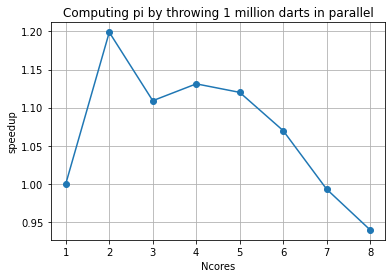

In [33]:
speedup = times[0]/times
plt.plot(Ncores, speedup, 'o-', label='actual')
plt.title('Computing pi by throwing 1 million darts in parallel')
plt.gca().set(xlabel='Ncores', ylabel='speedup', xticks=Ncores);
plt.grid()

In [34]:
N = 250_000_000
times = np.array([timeit(lambda: calculate_pi_parallel(N//Nc, Nc), number=1) for Nc in Ncores])

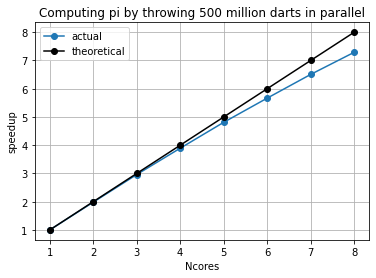

In [35]:
speedup = times[0]/times
plt.plot(Ncores, speedup, 'o-', label='actual')
plt.plot(Ncores, Ncores, 'o-', color='k', label='theoretical')
plt.title('Computing pi by throwing 250 million darts in parallel')
plt.gca().set(xlabel='Ncores', ylabel='speedup', xticks=Ncores);
plt.grid()
plt.legend()